<a href="https://colab.research.google.com/github/saxenabhishek/ImageCaptioningWithPyTorch/blob/master/Image_Captioning_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning using PyTorch
We are going to be trying to achieve the task of captioning an image using PyTorch.

## Importing Libraries
Let us start by importing necessary libraries.

In [ ]:
import json
import os

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms
from torchvision.utils import make_grid


Let us now download and unzip the Flickr8K dataset from kaggle.

In [ ]:
api_token = {"username":"kaafibored","key":"adbc1af3bce19b253dbe30a5a554f601"}
 
!mkdir /root/.kaggle

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
    
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:15<00:00, 57.3MB/s]
100% 1.04G/1.04G [00:15<00:00, 71.4MB/s]


In [ ]:
# Extracting the Zip file
import zipfile
zip_ref = zipfile.ZipFile("/content/flickr8k.zip", 'r')
zip_ref.extractall()
zip_ref.close()

##Data

This Dataset has a folder 'images' with all the images in it and a captions.csv file which contains the image name and caption, like shown below.

Captions.csv
___

| Image names 	| Caption                 	|
|-------------	|-------------------------	|
| 001.jpg     	| TeXt LiKe ThIs          	|
| 002.jpg     	| 1 Dog And 3 Cats 😊    	|
| 003.jpg     	| "Space" a young Baby .  	|

##Defining some variables

In [ ]:
# The no. Of word classes
top_k = 3000

# Encoded vector size
vecsize = 3000

# Batch size
BATCH_SIZE = 1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocessing

Let us now read the captions and process these captions to prepare to put them through our encoder.

In the following code cell we are going to be turning every word to lower case and removing numbers to avoid unwanted classes during tokenization.


In [ ]:
TableData = pd.read_csv("/content/captions.txt")
# lowercase the test
TableData["caption"]=TableData.caption.apply(lambda a:a.lower())

# remove any numbers in the text
import re
TableData["caption"]=TableData.caption.apply(lambda a:re.sub(r"\d+", "", a))

# remove extra spaces on the left or the right 
TableData["caption"]=TableData.caption.apply(lambda a:a.strip())

# add START and END tags
TableData["caption"]=TableData.caption.apply(lambda a:"START "+str(a)+" END")

In [ ]:
# This is how the captions look like now
TableData["caption"]

0        START a child in a pink dress is climbing up a...
1          START a girl going into a wooden building . END
2        START a little girl climbing into a wooden pla...
3        START a little girl climbing the stairs to her...
4        START a little girl in a pink dress going into...
                               ...                        
40450    START a man in a pink shirt climbs a rock face...
40451    START a man is rock climbing high in the air ....
40452    START a person in a red shirt climbing up a ro...
40453            START a rock climber in a red shirt . END
40454    START a rock climber practices on a rock climb...
Name: caption, Length: 40455, dtype: object

Assign tokens to top (TOP_K) words from the training dataset. All other words would get the tag "unk"

In [ ]:
import tensorflow.keras.preprocessing.text as text

tokenizer = text.Tokenizer(num_words=top_k,
                           oov_token="<unk>",
                           filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                           lower = False)

# All the captions
AllTheTrnText = TableData.caption.values

# Show the Tokenizer all the words
tokenizer.fit_on_texts(AllTheTrnText)

# Convert all captions into their encoded forms
TableData["encoded"] = TableData.caption.apply(lambda a:tokenizer.texts_to_sequences([a]))

Words that appear more often are given a lower index. You can check for the index for any word in the next block.

In [ ]:
tokenizer.sequences_to_texts([[9]])

['and']

In [ ]:
# Batches can't be formed if all Sequences are of different length. Padding is
# one solution but it introduces noise which makes its hard to converge.

# testTable["encoded"] = testTable.encoded.apply(lambda a:tf.keras.preprocessing.sequence.pad_sequences(a,maxlen = 38,value = 0,padding='post'))

# Min and Max lenght of sequences
length = [len(i[0]) for i in TableData.encoded.values]
min(length),max(length)

(3, 38)

## Processed Captions

In [ ]:
TableData.head(5)

,image,caption,encoded
0,1000268201_693b08cb0e.jpg,START a child in a pink dress is climbing up a...,"[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394,..."
1,1000268201_693b08cb0e.jpg,START a girl going into a wooden building . END,"[[3, 2, 20, 317, 65, 2, 197, 118, 4]]"
2,1000268201_693b08cb0e.jpg,START a little girl climbing into a wooden pla...,"[[3, 2, 41, 20, 120, 65, 2, 197, 2432, 4]]"
3,1000268201_693b08cb0e.jpg,START a little girl climbing the stairs to her...,"[[3, 2, 41, 20, 120, 6, 395, 21, 61, 2432, 4]]"
4,1000268201_693b08cb0e.jpg,START a little girl in a pink dress going into...,"[[3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197..."


## Dataloader
In the following block we are going to define a custom dataloader which makes it convinent to load and process the images and returns the corresponding captions with it.

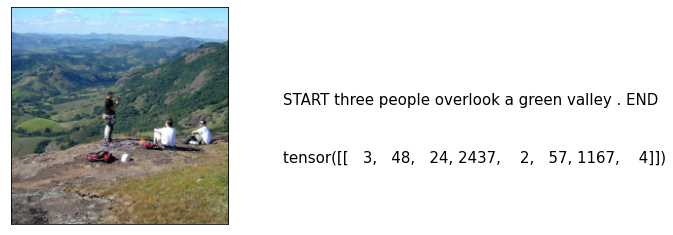

In [ ]:
from torch.utils.data import Dataset

class img2seq(Dataset):
    def __init__(self, df):
        """
        DF: the dataframe created above 
    

        img2seq(DF)[idx] 
        -->
        dic(["image"]:   Normalised tensor of the image at idx,
            ["caption"]: Encoded caption at idx,
            ["Text"]:    Text of idx )
        """
        self.df = df
        self.tera = transforms.Compose([transforms.Resize(224),
                           transforms.CenterCrop(224),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        idx : (int) Index of the data
        """
        #assert len(self.df) > idx
        ImgName = self.df.image.iloc[idx]
        openimg = Image.open("/content/Images/"+ImgName)
        image = self.tera(openimg)
        caption = torch.tensor(self.df.encoded.iloc[idx],dtype = torch.long)
        return {"image":image,"caption":caption,"text":self.df.caption.iloc[idx]}


# Example of how it is used
exampleidx = 158

plt.imshow(np.transpose(((img2seq(TableData)[exampleidx]["image"].numpy() + 1.0)/2.0),(1,2,0)))
plt.text(280.0,100.0,img2seq(TableData)[exampleidx]["text"],fontsize = 15)
plt.text(280.0,160.0,img2seq(TableData)[exampleidx]["caption"],fontsize = 15)
plt.xticks([]);plt.yticks([])
plt.show()

## Defining classes 
We are going to be using an Encoder-Decoder recurrent neural network architecture developed for machine translation which has proven effective when applied to the problem of text summarization.



![alt text](https://www.researchgate.net/profile/Gao_Huang/publication/321325862/figure/fig3/AS:667766038224897@1536219238694/The-proposed-DenseNet-variant-It-differs-from-the-original-DenseNet-in-two-ways-1.png)

###Encoder

The Encoder takes the image as it's input and gives us a vector of some fixed size. This vector contains all information about the image which will be used to predict captions. We have used a pretrained densnet model as our encoder because of it's relatively small size.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, unit_size = 3000):
        """
        Trained densenet201 encoder

        unit_size: Size of encoded output vector
        """
        super(EncoderCNN, self).__init__()
        
        # Densenet model
        self.densenet = models.densenet201(pretrained=True)

        # Freeze layers
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a fully connected layer, elu and dropout
        self.densenet.classifier = nn.Sequential(nn.ELU(),
                                                 nn.Dropout(p=0.1),
                                                 nn.Linear(in_features = 1920,out_features=unit_size))
                
    def forward(self, images):
        return self.densenet(images)


![alt text](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

### Decoder

The Decoder uses the encoded vector form of the image to predict the caption.
We are going to be decoding using Attention, which will avoid longer computation done by examining the whole image at once but rather look for sections of interest and focus on them.

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,bs = 16):
        """
        Decoder with GRU and Attention

        hidden_size: Size of Encoded vector
        output_size: Size of Word Classes
        dropout_p  : Dropout in the embedding layer
        bs         : Batch Size
        """
        super(AttnDecoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.bs = bs

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,input, x,hidden):
        """
        input  : Token form last layer. START if first layer
        x      : Encoded Vector
        hidden : Hidden vector from GRU, Context

        -->
        Confidence scores for each class
        """
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax( self.attn( torch.cat( (embedded, hidden), 2)), dim=1)
        attn_applied =  (x*attn_weights)

        output = torch.cat((embedded, attn_applied), 2)
        output = self.attn_combine(output)
        output = F.relu(output)

        # (Batch Size, Seq Len, Hidden Vector)
        output, hidden = self.gru(output, hidden.view(1,self.bs,-1))

        hidden = hidden.view(self.bs,1,-1)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        """
        Get zeros for first hidden input
        """
        return torch.zeros(self.bs, 1, self.hidden_size, device=device)



##Training Model 



### Simplified version of dataflow

The next block demonstrates how a datapoint goes through this network and how the loss is calculated for it.

In [ ]:

temp_dataloader = torch.utils.data.DataLoader(img2seq(TableData[:200]),batch_size=1,shuffle=True, num_workers=2)
SampleTest = next(iter(temp_dataloader))

print("Shape of the image ", SampleTest["image"].shape,"\n",
      "Shape of the caption ", SampleTest["caption"].shape,sep = "")


with torch.no_grad():
    enc = EncoderCNN(vecsize)
    enc.to(device)

    feat = enc(SampleTest["image"].to(device))

    print(f"Shape of encoded vector {feat.shape}")

    dec = AttnDecoderRNN(vecsize, top_k, bs = BATCH_SIZE)
    dec.to(device)

    output,hidden,weights = dec(SampleTest["caption"][:,:,0].to(device),
                                 feat,
                                 dec.initHidden().to(device))
    print(f"Shape of output vector {output.shape} \nShape of hidden vector {hidden.shape} ")

    # don't need them anymore
    del dec
    del enc
    del temp_dataloader
    del hidden

    # useful for trainig with multiple classes
    criterion = nn.NLLLoss()

    ls = criterion(output,
                   SampleTest["caption"][:,:,1].squeeze(0).to(device))
    
    print(f"loss for the test {ls.item()}")

    # index of the highest element
    topv,topi = output.data.topk(1)

    print()
    print(f"Highest index is {topi} with the value {topv} \ncompared with", SampleTest["caption"][:,:,1].data )
    
    torch.cuda.empty_cache()
    

Shape of the image torch.Size([1, 3, 224, 224])
Shape of the caption torch.Size([1, 1, 9])
Shape of encoded vector torch.Size([1, 3000])
Shape of output vector torch.Size([1, 3000]) 
Shape of hidden vector torch.Size([1, 1, 3000]) 
loss for the test 7.95137357711792

Highest index is tensor([[2282]], device='cuda:0') with the value tensor([[-7.8158]], device='cuda:0') 
compared with tensor([[2]])


In [ ]:
# Initialise
enc = enc = EncoderCNN(vecsize)
dec =  AttnDecoderRNN(vecsize, top_k, bs = BATCH_SIZE)
dataloader = torch.utils.data.DataLoader(img2seq(TableData[:3200]),batch_size=1,shuffle=True, num_workers=2)

The step function passes data through the model and collects outputs.

In [ ]:
def step(encoder,decoder,sample,encoder_optimizer,decoder_optimizer,criterion,forcer = 0):
    """

    encoder           : Encoder model
    decoder           : Decoder model
    forcer            : Probrability for using Teacher Forcer. 1 for TF only, 0 for BPTT
    sample            : A single data point (image, caption, text)
    encoder_optimizer : 
    decoder_optimizer :
    criterion         : Loss function
    

    pass image input through encoder
    get inputs for decoder: inithiden, vector, x<start>
    teacher forcer probrablity
    implment loss backwards propagate

    -->
    Loss, Predicted output sequence

    """
    loss = 0 

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    img = sample["image"].to(device)
    cap = sample["caption"].to(device)

    bs = img.shape[0]

    hidden = decoder.initHidden()
    outvec  = encoder(img)

    use_forcing = True if random.random() > forcer else False

    seqlength = sample["caption"].size(2)
    outseq = [] 
    
    if use_forcing:
        for j in range(seqlength - 1):
            output,hidden,_ = dec(cap[:,:,j], outvec,hidden)
            loss += criterion(output,cap[:,:,j + 1].view(-1))
            topv, topi = output.topk(1)
            token = topi.detach().cpu().numpy()
            outseq.append(tokenizer.sequences_to_texts(token)[0])
    else:
        input = torch.ones((bs,1),dtype = torch.long).to(device)* 3

        for j in range(1,seqlength):
            output,hidden,_ = dec(input, outvec, hidden)
            loss += criterion(output,cap[:,:,j].view(-1))
            topv, topi = output.topk(1)
            input = topi.clone().to(device)
            token = topi.clone().detach().cpu().numpy()
            outseq.append(tokenizer.sequences_to_texts(token)[0])
            if "END" in outseq[-1]:
                break

                
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()/len(outseq), outseq

# to test step
if 0:
    encoder_optimizer = optim.SGD(enc.parameters(), lr=0.01)
    decoder_optimizer = optim.SGD(dec.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    print(step(enc.to(device),dec.to(device),next(iter(dataloader)),encoder_optimizer,decoder_optimizer,criterion,1))

The trainiter fucntion calls the step function to train the model and handel epochs while displaying relevent stats

In [ ]:

from time import time as tim

def givetim(time):
    """
    Returns time spent with better formatting
    """
    in_mins = (tim() - time)/60
    if  in_mins < 1 :
        return str(in_mins*60) + " sec"
    else :
        return str(in_mins) + " mins"

def trainiter(encoder,decoder,dataloader,textonly = False,learning_rate=0.01,epoch = 5,disp = 100, saveat = None):
    """
    encoder  : Encoder Model
    decoder  : Decoder Model
    textonly : (bool) If only text output is required def. False 
    disp     : (int n) Display after going through n samples
    saveat   : Path to save file. Won't save it file isn't provided. 

    Gets Sample and performs SGD on it and collects loss
    prints some stats 
    records time for step
    plots graph for the loss
    """
    start = tim()
    lossplot = []

    encoder.to(device)
    decoder.to(device)

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for _ in range(epoch):
        startepoch = tim()
        disptime = tim()
        for i,sample in enumerate(dataloader):
            loss, outseq = step(encoder,decoder,sample,encoder_optimizer,decoder_optimizer,criterion,0.5)
            lossplot.append(loss)

            if i % disp == 0:
                 
                if saveat is not None:
                    torch.save(encoder.state_dict(),saveat+"encoder.pt")
                    torch.save(decoder.state_dict(),saveat+"decoder.pt")
                    print("Saved")


                text = (f"[{_}/{i/len(dataloader)*100}%]    loss: {loss}    time: {givetim(disptime)} \n" +
                        " ".join(outseq) +
                        " -->\n"+ sample["text"][0])
                
                if textonly:
                    print(text)
                else:
                    img = (sample["image"][0].cpu().squeeze(0).numpy() + 1.0)/2.0
                    plt.imshow(np.transpose(img,(1,2,0)))
                    plt.text(280.0,150.0,text,fontsize = 15)
                
                    plt.xticks([])
                    plt.yticks([])
                    plt.show()
                disptime = tim()
                print("")

        print(f"This epoch took { givetim(startepoch) } \n")
    print(f"Total Training time:{givetim(start)} \n ")

    plt.plot(lossplot)
    plt.show()

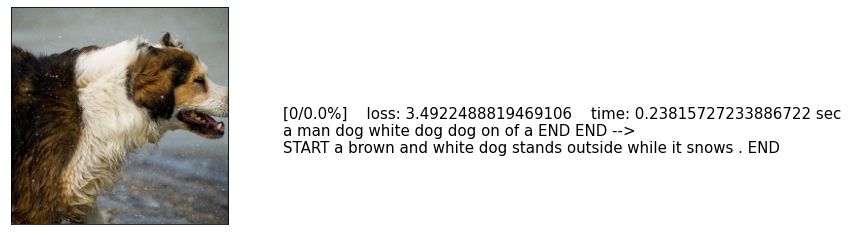

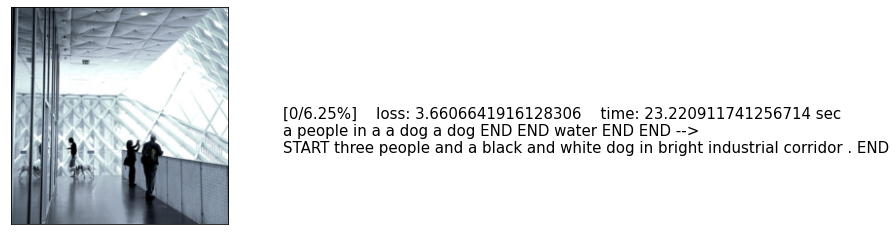

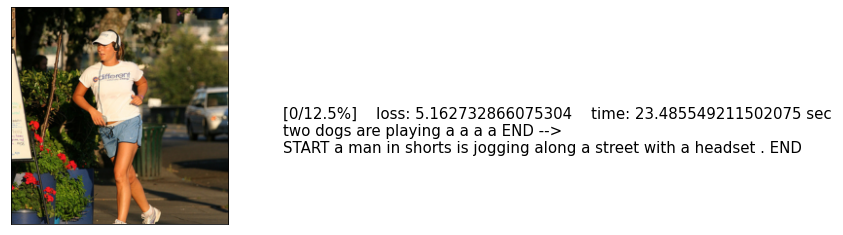

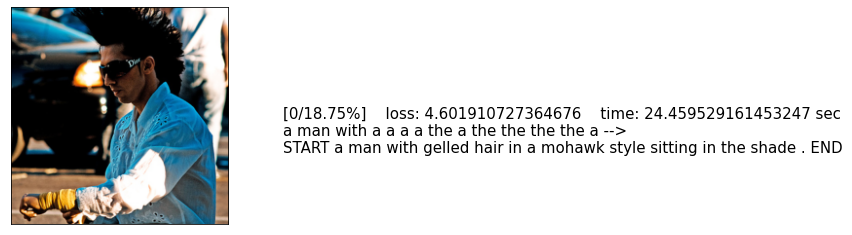

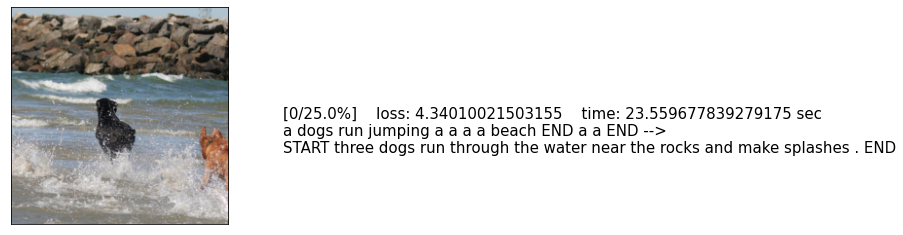

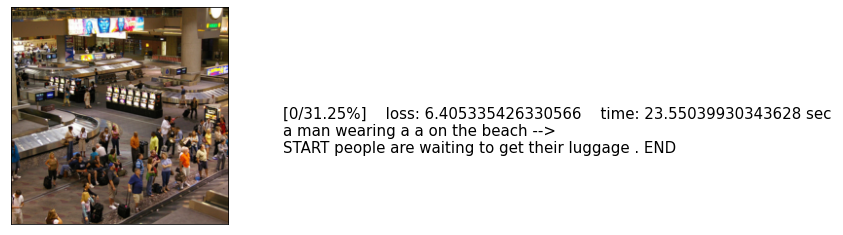

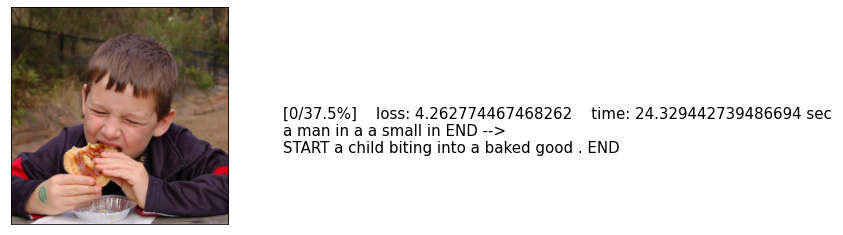

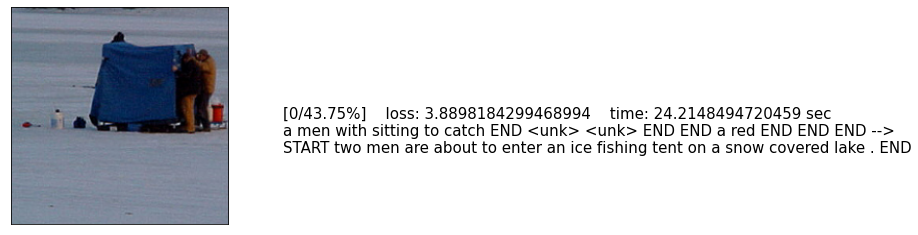

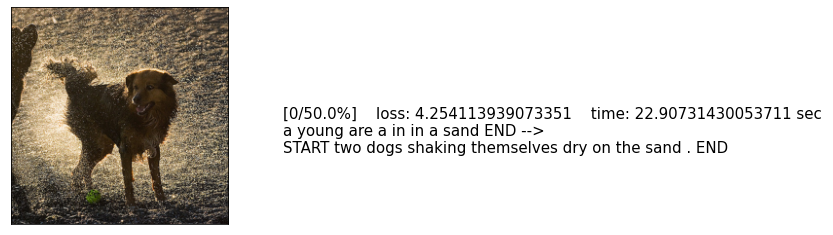

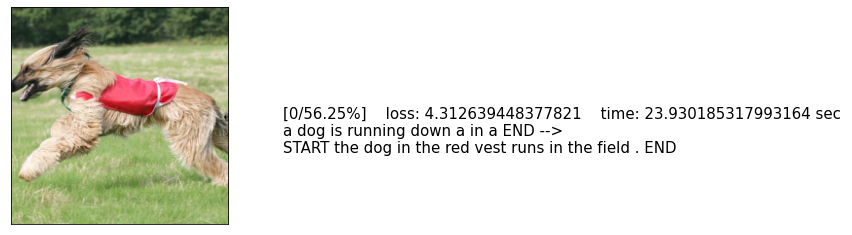

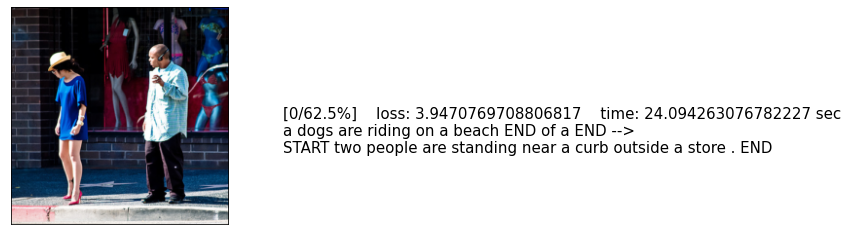

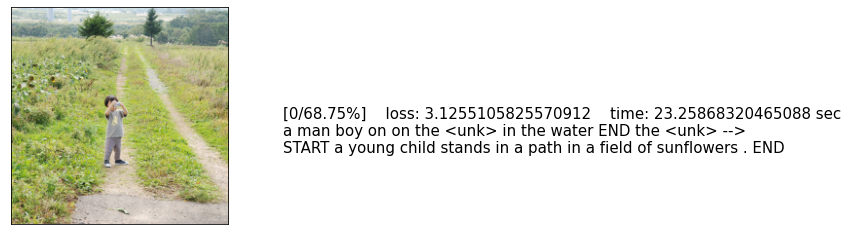

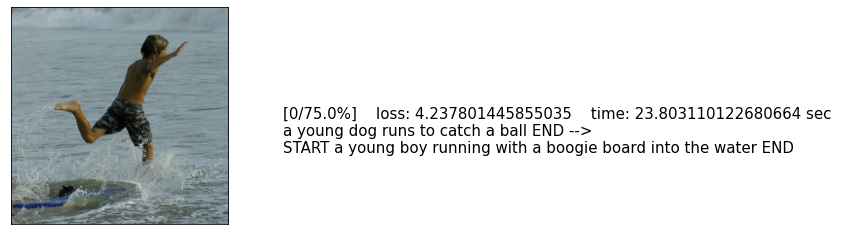

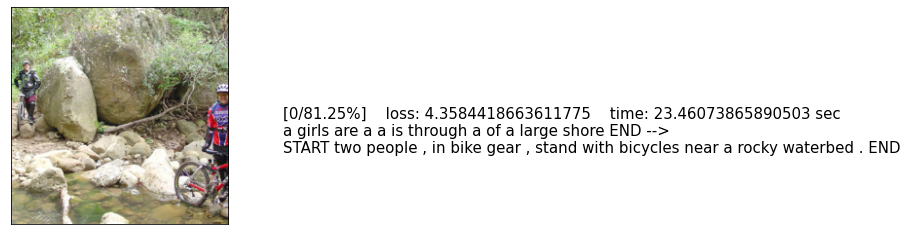

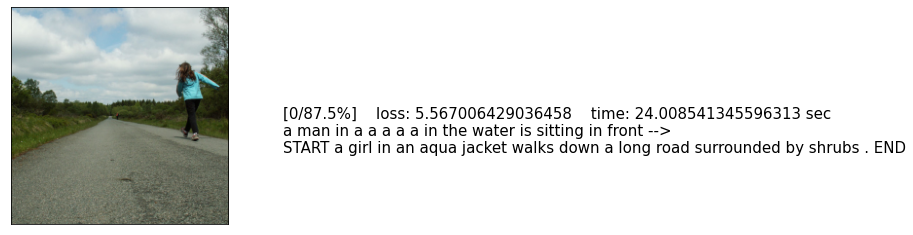

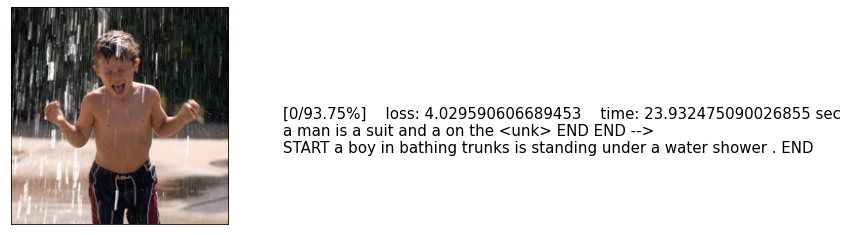


This epoch took 6.371713133653005 mins 

Total Training time:6.371953248977661 mins 
 


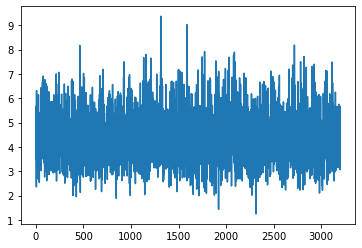

In [ ]:
trainiter(enc, dec, dataloader,textonly=False,epoch = 1,disp =200)